In [ ]:
# -------------------------------- Pnuemonia Detection ----------------------------

import os
from glob import glob
import torch
from collections import OrderedDict
import matplotlib.pyplot as plt
from torchvision import datasets, transforms, models
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# changing working directory
path = "/content/drive/MyDrive/Chest X-Rays.v2-resized-640by640.folder"
os.chdir(path)
print(os.getcwd())

print("Folders in directory",end=" - ")
print(os.listdir())

# Total image files in directory
n_files = len([x for x in glob(os.path.join('*','*','*.jpg'))])
print("Total image files : ",n_files)

/content/drive/MyDrive/Chest X-Rays.v2-resized-640by640.folder
Folders in directory - ['README.dataset.txt', 'README.roboflow.txt', 'train', 'test', 'valid']
Total image files :  5824


Total images: 5824, PNEUMONIA: 4245, NORMAL: 1579


Text(0, 0.5, 'COUNT')

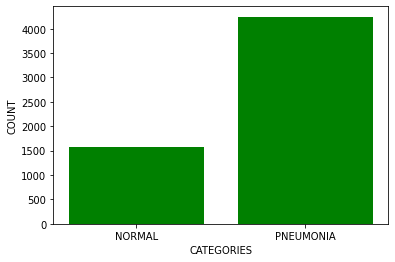

In [ ]:
data = {}
data['NORMAL'] = len([x for x in glob(os.path.join('*','NORMAL','*.jpg'))])
data['PNEUMONIA'] = len([x for x in glob(os.path.join('*','PNEUMONIA','*.jpg'))])
plt.bar( data.keys(),data.values(), color='green')
print("Total images: {}, PNEUMONIA: {}, NORMAL: {}".format(n_files, data['PNEUMONIA'], data['NORMAL']))
plt.xlabel("CATEGORIES")
plt.ylabel("COUNT")

In [ ]:
# transformations on images
trans_train = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])

trans = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])

# Creating datasets using ImageFolder module
test_data = datasets.ImageFolder(os.path.join(path,"test"), transform = trans)
train_data = datasets.ImageFolder(os.path.join(path,"train"), transform = trans_train)
val_data = datasets.ImageFolder(os.path.join(path,"valid"), transform = trans)

#creating Data Loaders
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=True)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=64, shuffle=True)

Images shape :torch.Size([64, 3, 256, 256]) 
Label for 1st image :  PNEUMONIA
{'NORMAL': 0, 'PNEUMONIA': 1}


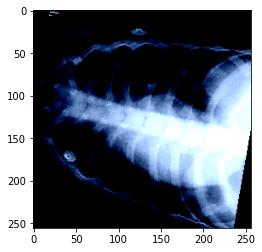

In [ ]:
#peek in data
categories = ['NORMAL', 'PNEUMONIA']
img, label = next(iter(train_loader))
print("Images shape :{} ".format(img.size()))
print("Label for 1st image : ",categories[label[0]])
plt.imshow(img[0].numpy().transpose())
#labels
print(train_data.class_to_idx)

In [ ]:
# using densenet121 pretrained model
model = models.densenet121(pretrained=True)
# set no grad as we are not going to modify weights of pretrained model except for last layer
for param in model.parameters():
    param.requires_grad = False

in_feature = model.classifier.in_features # in_feature for input to custom layers
print("Input for classifier ",in_feature)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]

Input for classifier  1024


In [ ]:
# modifying classifier layer
model.classifier = torch.nn.Sequential(OrderedDict([
    ('layer1',torch.nn.Linear(in_feature,256)),
    ('ReLU1', torch.nn.ReLU()),
    ('dp1', torch.nn.Dropout(0.2)),
    ('layer2', torch.nn.Linear(256,32)),
    ('ReLU2', torch.nn.ReLU()),
    ('Output', torch.nn.Linear(32,2)),
    ('LogSoftmax', torch.nn.LogSoftmax(dim=1))
]))
model.classifier

Sequential(
  (layer1): Linear(in_features=1024, out_features=256, bias=True)
  (ReLU1): ReLU()
  (dp1): Dropout(p=0.2, inplace=False)
  (layer2): Linear(in_features=256, out_features=32, bias=True)
  (ReLU2): ReLU()
  (Output): Linear(in_features=32, out_features=2, bias=True)
  (LogSoftmax): LogSoftmax(dim=1)
)

In [ ]:
total_parameters = sum([p.numel() for p in model.parameters()])
trainable_parameters = sum([p.numel() for p in model.parameters() if p.requires_grad==True])
print("Total parameters : {} | Trainable Parameters : {} ".format(total_parameters,trainable_parameters))

Total parameters : 7224546 | Trainable Parameters : 270690 


In [ ]:
#Validation Function
def validation(model, val_loader, gpu):
    steps = 0
    with torch.no_grad():
        model.eval()
        val_loss = 0
        val_acc = 0
        steps += 1
        for images, labels in val_loader:
            if gpu:
                images, labels = images.cuda(), labels.cuda()
            out = model(images)
            loss = loss_fun(out, labels)
            val_loss+=loss.item()*images.size(0)
            output = torch.nn.functional.softmax(out,dim=1)
            val_acc+=(output.max(1)[1] == labels.data).type(torch.FloatTensor).mean()
    print("Validation Loss : {} | Validation accuracy : {} ".format(val_loss/steps, val_acc*100/steps))
    return val_loss/steps, val_acc*100/steps


In [ ]:
gpu = torch.cuda.is_available()
print("GPU available : {} ".format(gpu))
if gpu:
    dev = torch.cuda.device_count()
    if dev>1:
        multi_dev = True
    else:
        multi_dev = False
    print("No of devices : {} ".format(dev))
    for _ in range(dev):
        print("Device - ",torch.cuda.get_device_name(_))

GPU available : False 


In [ ]:
epochs = 5
loss_fun = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [ ]:
# transfer to GPU if available
if gpu:
    model = model.to(torch.device('cuda'))
    print("Model is now on GPU")
else:
    print("Model is on CPU")

Model is on CPU


In [ ]:
# Training Model
train_loss = 0
train_acc = 0
loss_list=[]
best={
    'epoch':0,
    'train_loss':0,
    'train_acc':0,
    'val_acc':0,
    'val_loss':0,
    'state_dict':None
}
model.train()
for e in range(epochs):
    steps=0
    for images, labels in train_loader:
        steps+=1
        if gpu:
            images, labels = images.cuda(), labels.cuda()
        output = model(images)
        optimizer.zero_grad()
        loss = loss_fun(output, labels)
        loss.backward()
        optimizer.step()
        train_acc+=(output.max(1)[1]==labels.data).type(torch.FloatTensor).mean()
        train_loss+=loss.item()*images.size(0)
    print("Epoch {} / {} completed ".format(e+1,epochs))
    print("Training Accuracy : {}".format(train_acc*100/steps))
    print("Training Loss : {}".format(train_loss/steps))
    val_loss, val_acc = validation(model, val_loader, gpu)
    loss_list.append(train_loss/steps)
    print("---------------------------------------------------------------------------------------")
    if (train_acc*100/steps)>=best['train_acc']:
        best['epoch'] = e+1
        best['train_loss'] = train_loss/steps
        best['train_acc'] = train_acc*100/steps
        best['val_loss'] = val_loss
        best['val_acc'] = val_acc
        best['state_dict'] = model.state_dict()
    train_loss = 0
    train_acc = 0

print("Best Epoch: {} with\n training loss: {} | training accuracy: {} |\n validation loss: {} | validation accuracy: {}".
format(best['epoch'], best['train_loss'], best['train_acc'], best['val_loss'], best['val_acc']))
model.load_state_dict(best['state_dict'])

Epoch 1 / 5 completed 
Training Accuracy : 81.13172912597656
Training Loss : 26.990799690014683
Validation Loss : 231.23793604969978 | Validation accuracy : 1745.5528564453125 
---------------------------------------------------------------------------------------
Epoch 2 / 5 completed 
Training Accuracy : 93.84114837646484
Training Loss : 10.866711545735598
Validation Loss : 318.49774792790413 | Validation accuracy : 1703.3653564453125 
---------------------------------------------------------------------------------------
Epoch 3 / 5 completed 
Training Accuracy : 94.25618743896484
Training Loss : 9.866333211539313
Validation Loss : 173.332536064554 | Validation accuracy : 1785.9375 
---------------------------------------------------------------------------------------
Epoch 4 / 5 completed 
Training Accuracy : 93.92469787597656
Training Loss : 9.901650723535568
Validation Loss : 203.2477990835905 | Validation accuracy : 1761.0576171875 
---------------------------------------------

<All keys matched successfully>

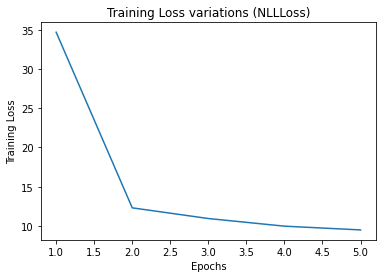

In [ ]:
# Training Loss
plt.plot(range(1,len(loss_list)+1), loss_list )
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.title("Training Loss variations (NLLLoss)")
plt.show()

L- Label, P- Prediction


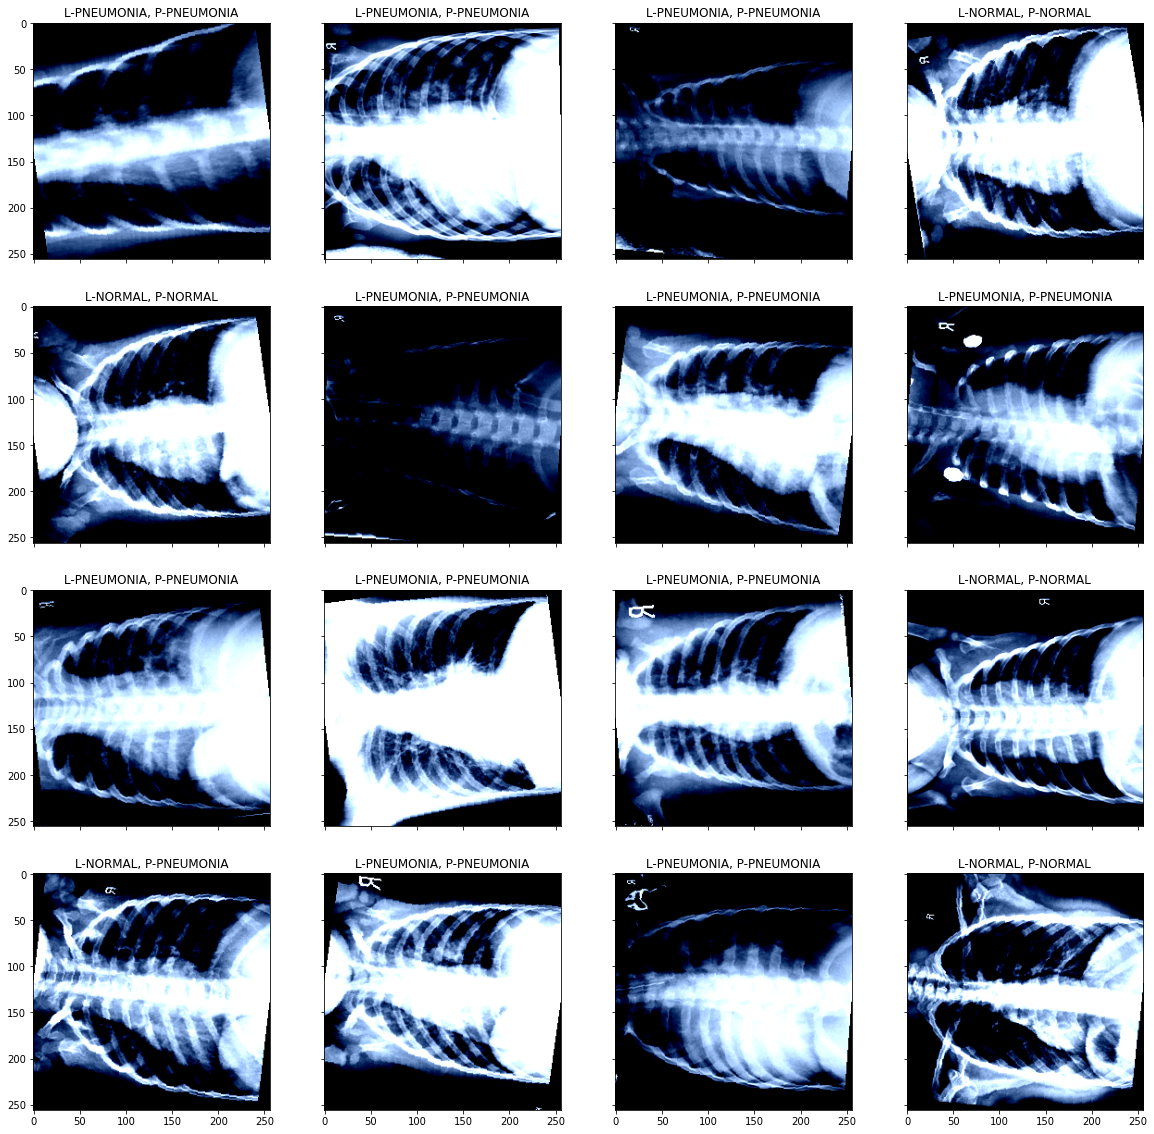

In [ ]:
# Hand testing
if gpu:
    model = model.to(torch.device('cpu'))
images, label = next(iter(train_loader))
output = model(images).max(1)[1]
fig, axs = plt.subplots(4,4, sharex=True, sharey=True, figsize=((20, 20)))
img_index=0
print("L- Label, P- Prediction")
for x in range(4):
    for y in range(4):
        axs[x][y].imshow(images[img_index].numpy().transpose())
        axs[x][y].title.set_text("L-{}, P-{}".format(categories[label[img_index]], categories[output[img_index]]))
        img_index+=1
plt.show()

In [ ]:
#Testing
model.eval()
steps = 0
test_loss = 0
test_acc = 0
if gpu:
    model = model.to(torch.device('cuda'))
for images, labels in test_loader:
    steps+=1
    if gpu:
        images, labels = images.cuda(), labels.cuda()
    output = model(images)
    test_loss+=loss_fun(output,labels).item()*images.size(0)
    test_acc+= (labels.data == output.max(1)[1]).type(torch.FloatTensor).mean()

print("Testing Loss : {} || Testing accuracy : {}".format(test_loss/steps, test_acc*100/steps))

Testing Loss : 8.918539694324135 || Testing accuracy : 94.84375
